In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils # need pip install
from random import randrange
from IPython.display import YouTubeVideo


## First, change the newPath variable below to point to the location of the tfrecords file, then run all of the cells in order to get the results. You can also comment and uncomment some parts to tune hyperparameters

In [7]:
newPath = "./audioset_v1_embeddings/myFiltered2/"
files = os.listdir( newPath )

oneFile=[]
allFiles=[]
myLabels=[]
myLabelsAll=[]
multiLabels=[]
ytid=[]
count=0;
ind=0;


for file in files:
    tfrecords_filename = newPath+file

    record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

    string_record = next(record_iterator)

    example = tf.train.SequenceExample()

    example.ParseFromString(string_record)    
    
    #to store the id of the video for later use
    vidId=example.context.feature['video_id'].bytes_list.value[0].decode()
    
    for a in example.feature_lists.feature_list['audio_embedding'].feature:
            # 960ms of data
        hexembed = a.bytes_list.value[0].hex()

        arrayembed = [int(hexembed[i:i+2],16) for i in range(0,len(hexembed),2)]         
        
        label=example.context.feature['labels'].int64_list.value[:]        
        
        #0, 72,137,300
        if 0 in label or 72 in label or 137 in label or 300 in label:
            allFiles.append(arrayembed)
            ytid.append(vidId)
            for x in label:
                if x in {0,72,137,300}:
                    myLabelsAll.append(label[label.index(x)]) #basically saying the first label in these categories is considered the only label                    
                    break
        
        

In [8]:
def counting(labels, df):
    for i, x in enumerate(labels):
        if x == 0:
            df.iloc[0,0]+=1

        if x == 72:
            df.iloc[0,1]+=1           

        if x == 137:
            df.iloc[0,2]+=1

        if x == 300:
            df.iloc[0,3]+=1
    print(df)    

In [9]:
def shuffling(allSamples,labels,sampleToShuffle, sampleLabel):
    X=allSamples    
    Y=labels
    x1=sampleToShuffle
    y1=sampleLabel
    
    r=[randrange(10) for _ in range(0,10)]
    for num in range(10):
        if(num < int(len(r)/2)):
            #print('1st is {0}, 2nd is {1}'.format(x[(len(x)-1)-num],num))
            temp=x1[num].copy()
            x1[num]=x1[r[num]].copy()#r[num] is the index num in the list r of random numbers between 1 and 10
            x1[r[num]]=temp.copy()    

    X=np.append(X, x1.reshape(1,10,128,1), axis=0)    
    Y=np.append(Y, y1)

    #print(len(X))
    
    return X, Y
            




In [10]:
count=0
newLabels=[]
ytidNew=[]


for i in range(0, len(myLabelsAll)):
    if i%10==0:
        newLabels.append(myLabelsAll[i])
        ytidNew.append(ytid[i])
        #multiLabelsNew.append(y_multi[i]) # for future

yLabel=[]

newLabelsFiltered=newLabels
ind=0
count0=0
count137=0
count72=0
count300=0

X = np.array(allFiles)
X=X.reshape(int(len(X)/10),10,128,1) # no of 10 s clips, first dimension, 2nd dimension, 1 channel

indList=[]
        
df = pd.DataFrame(columns = ["speech", "Animal", "Music", "Vehicle"])
df=df.append({"speech":0, "Animal":0, "Music":0, "Vehicle":0}, ignore_index=True)

print(len(X))            
X=np.delete(X, indList, axis=0)
print(len(X))

#shuffle around data in each sample for the samples that don't have much data, and append it as a new sample
while count72<=300: # count72 is for Animal label
    count72=0
    count300=0
    for i, x in enumerate(newLabelsFiltered):
        if x == 72 and count72<=300:
            count72+=1
            X, newLabelsFiltered =shuffling(X, newLabelsFiltered, X[i], x)
            ytidNew.append(ytidNew[i])
        if x == 300 and count300<=300:
            count300+=1
            X, newLabelsFiltered =shuffling(X, newLabelsFiltered, X[i], x)
            ytidNew.append(ytidNew[i])
    if count72>300:
        break
    #print(count72)

counting(newLabelsFiltered, df)
     
encoder = LabelEncoder()
encoder.fit(newLabelsFiltered)
encoded_Y = encoder.transform(newLabelsFiltered)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

xtr, xte, ytr, yte = train_test_split(X,dummy_y,test_size = 0.40, random_state = 0) #one-hot encoding version
#xtr, xte, ytr, yte = train_test_split(X,encoded_Y,test_size = 0.40, random_state = 0)# regular encoded version (for sparse categorical cross entropy)

xtr=xtr/255
xte=xte/255

np.save('XTrain', xtr)
np.save('Xtest', xte)
np.save('YTrain', ytr)
np.save('Ytest', yte)
np.save('XFull', X)
np.save('ytidNew', np.array(ytidNew))



3529
3529
   speech  Animal  Music  Vehicle
0    1951     621   1369     1241


In [25]:
np.save('encoded', np.array(dummy_y))

In [32]:

model = keras.Sequential()

model.add(keras.layers.Conv2D(16, kernel_size=(1, 6), strides=(2, 2), activation='relu',input_shape=(10,128,1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(keras.layers.Conv2D(32, kernel_size=(1, 6), strides=(1, 1), activation='relu',padding="same"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(keras.layers.Conv2D(32, kernel_size=(1, 6), strides=(1, 1), activation='relu',padding="same"))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))# testing

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))


In [30]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(10, activation='relu',input_shape=(1280,)))
model2.add(keras.layers.Dense(100, activation='relu'))
model2.add(keras.layers.Dense(1000, activation='relu'))
model2.add(keras.layers.Dense(4, activation='softmax'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
xtr2=xtr.reshape(len(xtr),10*128)
xte2=xte.reshape(len(xte),10*128)
print("\n=======================\n using 1280/10-100-1000 ONN\n=================\n")
model2.fit(xtr2, np.array(ytr), shuffle=True, batch_size=100, epochs=5)

test_loss, test_acc = model2.evaluate(xte2, np.array(yte))
#test_loss, test_acc = model.evaluate(xte, multiLabelsNew[2000:])
print(test_acc)


 using 1280/10-100-1000 ONN

Epoch 1/5
3109/3109 [==============================]3109/3109 [==============================] - 0s 102us/step - loss: 0.5167 - acc: 0.7523

Epoch 2/5
3109/3109 [==============================]3109/3109 [==============================] - 0s 43us/step - loss: 0.3930 - acc: 0.8192

Epoch 3/5
3109/3109 [==============================]3109/3109 [==============================] - 0s 43us/step - loss: 0.2981 - acc: 0.8772

Epoch 4/5
3109/3109 [==============================]3109/3109 [==============================] - 0s 42us/step - loss: 0.2570 - acc: 0.8940

Epoch 5/5
3109/3109 [==============================]3109/3109 [==============================] - 0s 42us/step - loss: 0.2712 - acc: 0.8874

2073/2073 [==============================]2073/2073 [==============================] - 0s 52us/step

0.8839845632333659



 =========================using 1280/10-100-1000 ONN ========================== 


the order of the Real labels is [speech, animal, music, vehicle]

0.) youtube id 5rks4FNDYPw has (a/an) music , Real label is [0. 0. 1. 0.]
1.) youtube id 0WYSS13Hqy8 has (a/an) music , Real label is [0. 0. 1. 0.]
2.) youtube id hZYFGJ2Tr_g has (a/an) music , Real label is [0. 0. 1. 0.]
3.) youtube id 3gFQwviPv9g has (a/an) human speaker , Real label is [1. 0. 0. 0.]
4.) youtube id MeAykJrFfJs has (a/an) music , Real label is [0. 0. 1. 0.]
5.) youtube id Lfl2GhUJsoY has (a/an) human speaker , Real label is [1. 0. 0. 0.]
6.) youtube id 5G05PSrnr1o has (a/an) vehicle , Real label is [0. 0. 0. 1.]
7.) youtube id 5X6q35fYKLc has (a/an) human speaker , Real label is [1. 0. 0. 0.]
8.) youtube id Bg0gtKsMV6E has (a/an) vehicle , Real label is [0. 0. 0. 1.]
9.) youtube id CCPJa-FjWho has (a/an) human speaker , Real label is [0. 0. 1. 0.]
10.) youtube id PJf16pkFAuI has (a/an) human speaker , Real label is [1. 0

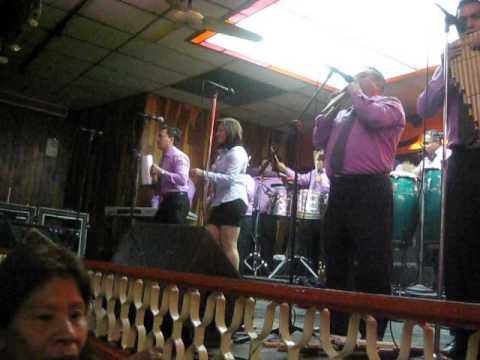

In [34]:
###### just predicting first 20 videos
pred = model2.predict(X[0:20].reshape(len(X[0:20]),10*128))
chosen = []
ind=0
for x in pred:
    if np.where(x == (max(x)))[0]==0:
        chosen.append('human speaker')
    if np.where(x == (max(x)))[0]==1:
        chosen.append('animal')
    if np.where(x == (max(x)))[0]==2:
        chosen.append('music')
    if np.where(x == (max(x)))[0]==3:
        chosen.append('vehicle')
        
#[human speaker, animal, music, vehicle] 
print("\n =========================using 1280/10-100-1000 ONN ========================== \n")
print("\nthe order of the Real labels is [speech, animal, music, vehicle]\n")
for i in ytidNew[0:20]:    
    print('{0}.) youtube id {1} has (a/an) {2} , Real label is {3}'.format(ind, i, chosen[ind], dummy_y[ind]))
    ind+=1

r = randrange(0,20)
    
print('\n ========= \n youtube video to verify prediction no {0} ({1}): \n'.format(r, chosen[r]))

YouTubeVideo(ytidNew[r]) # functionality imported from an IPython.display library

In [35]:
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
### 
#batch size 20 with 10 epochs was good

print("\n =========================using CNN ========================== \n")
model.fit(xtr, np.array(ytr), shuffle=True, batch_size=20, epochs=10)

test_loss, test_acc = model.evaluate(xte, np.array(yte))
print(test_acc)

Epoch 1/10
3109/3109 [==============================]3109/3109 [==============================] - 12s 4ms/step - loss: 0.5157 - acc: 0.7684

Epoch 2/10
3109/3109 [==============================]3109/3109 [==============================] - 13s 4ms/step - loss: 0.3303 - acc: 0.8572

Epoch 3/10
3109/3109 [==============================]3109/3109 [==============================] - 12s 4ms/step - loss: 0.2533 - acc: 0.8980

Epoch 4/10
3109/3109 [==============================]3109/3109 [==============================] - 12s 4ms/step - loss: 0.1951 - acc: 0.9246

Epoch 5/10
3109/3109 [==============================]3109/3109 [==============================] - 11s 4ms/step - loss: 0.1502 - acc: 0.9445

Epoch 6/10
3109/3109 [==============================]3109/3109 [==============================] - 13s 4ms/step - loss: 0.1061 - acc: 0.9609

Epoch 7/10
3109/3109 [==============================]3109/3109 [==============================] - 12s 4ms/step - loss: 0.0776 - acc: 0.9738

Epoch 8/10
31


the order of the Real labels is [speech, animal, music, vehicle]

0.) youtube id 5rks4FNDYPw has (a/an) music , Real label is [0. 0. 1. 0.]
1.) youtube id 0WYSS13Hqy8 has (a/an) music , Real label is [0. 0. 1. 0.]
2.) youtube id hZYFGJ2Tr_g has (a/an) music , Real label is [0. 0. 1. 0.]
3.) youtube id 3gFQwviPv9g has (a/an) human speaker , Real label is [1. 0. 0. 0.]
4.) youtube id MeAykJrFfJs has (a/an) music , Real label is [0. 0. 1. 0.]
5.) youtube id Lfl2GhUJsoY has (a/an) human speaker , Real label is [1. 0. 0. 0.]
6.) youtube id 5G05PSrnr1o has (a/an) vehicle , Real label is [0. 0. 0. 1.]
7.) youtube id 5X6q35fYKLc has (a/an) human speaker , Real label is [1. 0. 0. 0.]
8.) youtube id Bg0gtKsMV6E has (a/an) vehicle , Real label is [0. 0. 0. 1.]
9.) youtube id CCPJa-FjWho has (a/an) human speaker , Real label is [0. 0. 1. 0.]
10.) youtube id PJf16pkFAuI has (a/an) human speaker , Real label is [1. 0. 0. 0.]
11.) youtube id lKS7fQ42Zn4 has (a/an) music , Real label is [0. 0. 1. 0.]

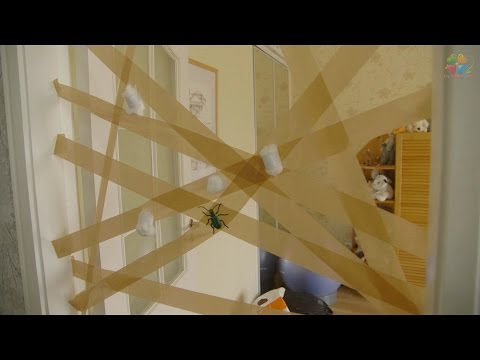

In [37]:
# just predicting first ten videos
pred = model.predict(X[0:20])
chosen = []
ind=0
for x in pred:
    if np.where(x == (max(x)))[0]==0:
        chosen.append('human speaker')
    if np.where(x == (max(x)))[0]==1:
        chosen.append('animal')
    if np.where(x == (max(x)))[0]==2:
        chosen.append('music')
    if np.where(x == (max(x)))[0]==3:
        chosen.append('vehicle')
        
#[human speaker, animal, music, vehicle]  
print("\nthe order of the Real labels is [speech, animal, music, vehicle]\n")
for i in ytidNew[0:20]:    
    print('{0}.) youtube id {1} has (a/an) {2} , Real label is {3}'.format(ind, i, chosen[ind], dummy_y[ind]))
    ind+=1

r = randrange(0,20)
    
print('\n ========= \n youtube video to verify prediction no {0} ({1}): \n'.format(r, chosen[r]))

YouTubeVideo(ytidNew[r]) # functionality imported from an IPython.display library

array([0., 0., 1., 0.], dtype=float32)

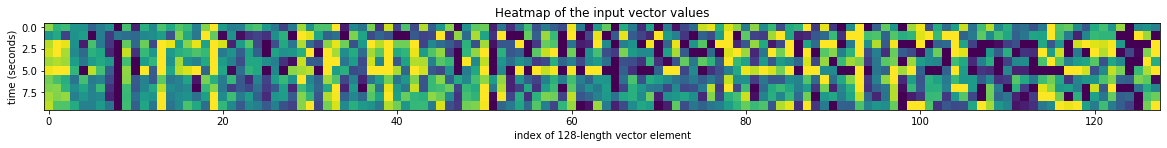

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(X[0].reshape(10,128))
plt.title('Heatmap of the input vector values')
plt.xlabel('index of 128-length vector element')
plt.ylabel('time (seconds)')
dummy_y[0]